In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import re
import unicodedata

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

#plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


#loading small corpus
nlp = spacy.load('en_core_web_sm')

#get data
df = pd.read_csv("/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv")


print("Setup Done!")

Setup Done!


In [3]:
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
#list of contractions and their related expansions (from web)
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"'ll": "will",
"'ve": "have",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"tbh":"to be honest" }

In [5]:
df.isna().sum()

email    1
label    0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.isna().sum()

email    0
label    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   2999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.3+ KB


In [9]:
df["label"].value_counts()

0    2500
1     499
Name: label, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   2999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.3+ KB


In [11]:
def get_avg_word_len(x):
    """Get the average word length from a given sentence
    param x(str): the sentence of whose word length is to be taken
    return leng(numeric): the average word length """

    words = x.split()
    word_len = 0
    for word in words:
        word_len = word_len + len(word)
    return word_len/len(words)

def feature_extract(df,d):
    """Adds new columns in the given df, from the existing data
    count: number of words in the document (df[d])
    char count: number of characters in df[d]
    avg word_len: the average number of characters in the df[d]
    stop_words_len: number of stopwords present
    numeric_count: number of numeric characters present
    upper_counts: number of words in CAPS LOCK
    polarity: sentiment of the word, from -1(negative) to 1(positive)
    
    param df(dataframe): dataframe on which manipulation is to be done
    param d(str): column name in which the reuired words are present"""
    
    df['count']=df[d].apply(lambda x: len(str(x).split()))
    df['char count']=df[d].apply(lambda x: len(x))
    #df['avg word_len'] = df[d].apply(lambda x:get_avg_word_len(x))
    df['stop_words_len'] = df[d].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))
    df['numeric_count'] = df[d].apply(lambda x:len([t for t in x.split()if t.isdigit()] ))
    df['upper_counts'] = df[d].apply(lambda x: len([t for t in x.split() if t.isupper() and len(x)>3]))
    df['polarity'] = df[d].map(lambda text: TextBlob(text).sentiment.polarity)
    
#calling the function
feature_extract(df,'email')
f = df

print("Extraction complete: ")
print("Number of words, characters, stop words, numeric characters, upper case characters and polarity extracted")

In [12]:
df.head()

,email,label,count,char count,stop_words_len,numeric_count,upper_counts,polarity
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0,257,1522,70,0,45,0.010000
1,martin a posted tassos papadopoulos the greek ...,0,113,643,41,0,7,0.119333
2,man threatens explosion in moscow thursday aug...,0,256,1509,98,0,8,0.101500
3,klez the virus that won t die already the most...,0,169,1015,69,0,9,0.067695
4,in adding cream to spaghetti carbonara which ...,0,144,771,66,0,5,0.163333


In [13]:
def expand(x):
    """Some of the words like 'i'll', are expanded to 'i will' for better text processing
    The list of contractions is taken from the internet
    
    param x(str): the sentence in which contractions are to be found and expansions are to be done
    
    return x(str): the expanded sentence"""
    if type(x)== str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x

def remove_accented_chars(x):
    """The function changes the accented characters into their equivalent normal form,
    to do so, normalize function with 'NFKD' is used which replaces the compatibility characters into
    theri euivalent
    
    param x(str): the sentence in which accented characters are to be detected and removes
    return x(str): sentence with accented characters replaced by their equivalent"""
    
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x


def make_to_base(x):
    """Converting the words to their base word and dictionary head word i.e to lemmatize
    param x(str): the sentence in which the words are to be converted (lemmatization)
    return x(str): the lemmatized sentence"""
    
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = str(token.lemma_)
        
        #in spacy, words like I, you are lemmatized as -PRON- and are,and etc are lemmatized to be,
        #since these words are present widely, we keep them as the original. 
        #Anyways the words will be removed as stop words later
        
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text
        x_list.append(lemma)
    return (" ".join(x_list))



In [14]:
def preprocess(df,d):
    """Preprocesses the given document by applying the following functionalities
    lower: lowers all the characters for uniformity
    expansion: expands words like i'll to i will for better text classification
    remove special characters: using regex, removes all the punctuations etc
    remove space: removes trailing spaces and extra spaces between words
    remove accented characters: change accented characters to its normal equivalent
    remove stop words: removes the stop words in the sentence
    lemmatization: changes the words to their base form"""
    
    df[d] = df[d].apply(lambda x: x.lower())
    df[d] = df[d].apply(expand)
    df[d] = df[d].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))
    df[d] = df[d].apply(lambda x: " ".join(x.split()))
    df[d] = df[d].apply(lambda x: remove_accented_chars(x))
    df[d] = df[d].apply(lambda x: make_to_base(x))
    df[d] = df[d].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))

In [15]:
#calling the function
preprocess(df,'email')

print("Pre processing done!")

Pre processing done!


# Visualize

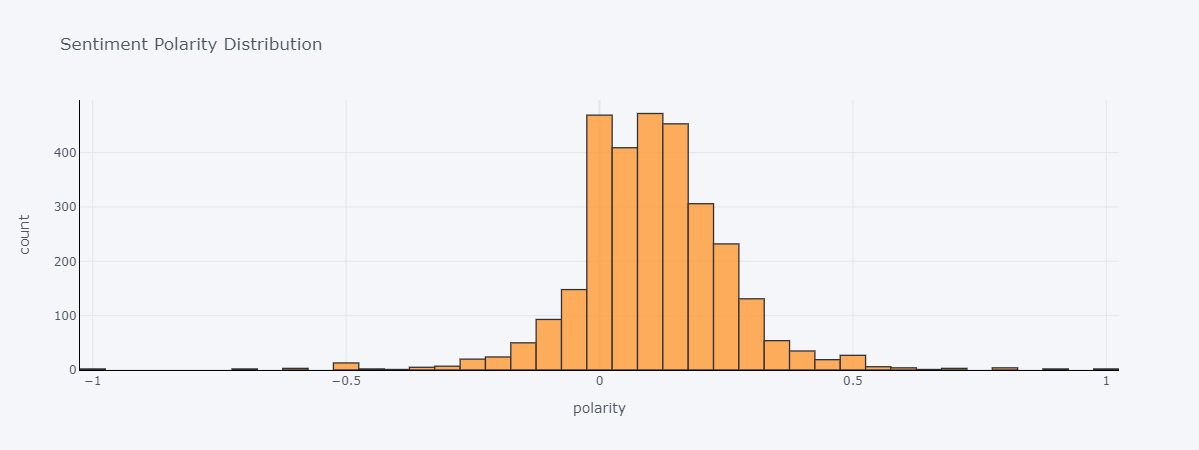

In [17]:
df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

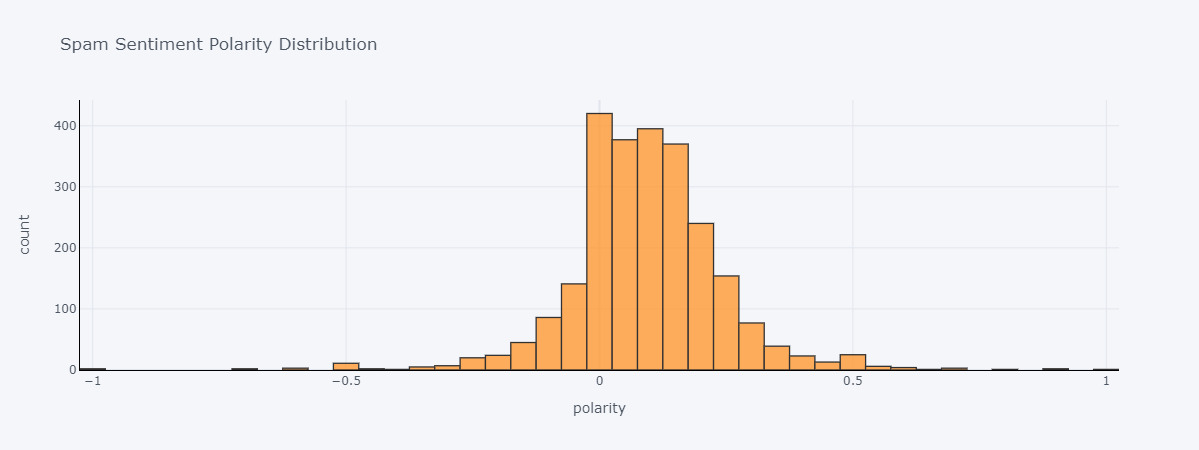

In [18]:
df[df['label']==0]['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Spam Sentiment Polarity Distribution')

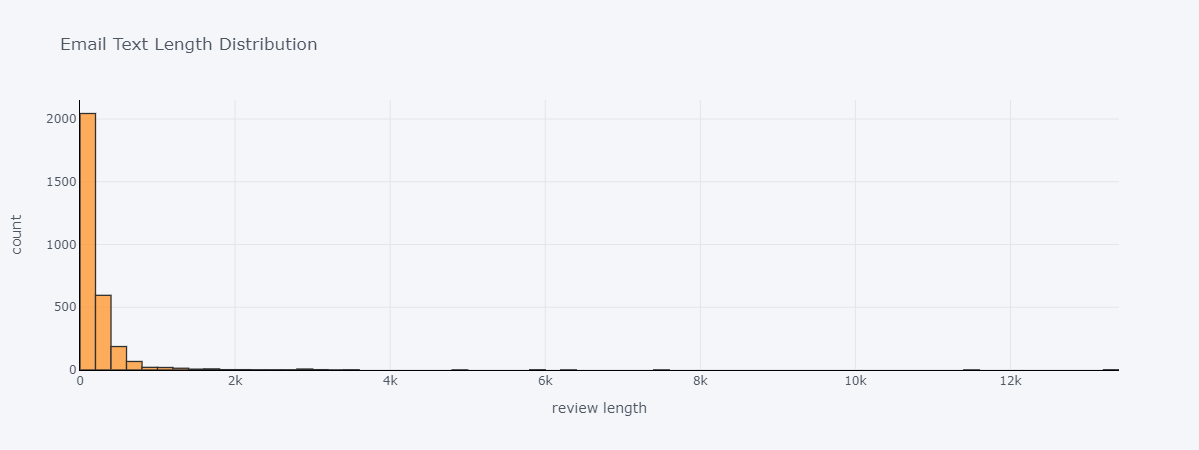

In [19]:
df['count'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Email Text Length Distribution')

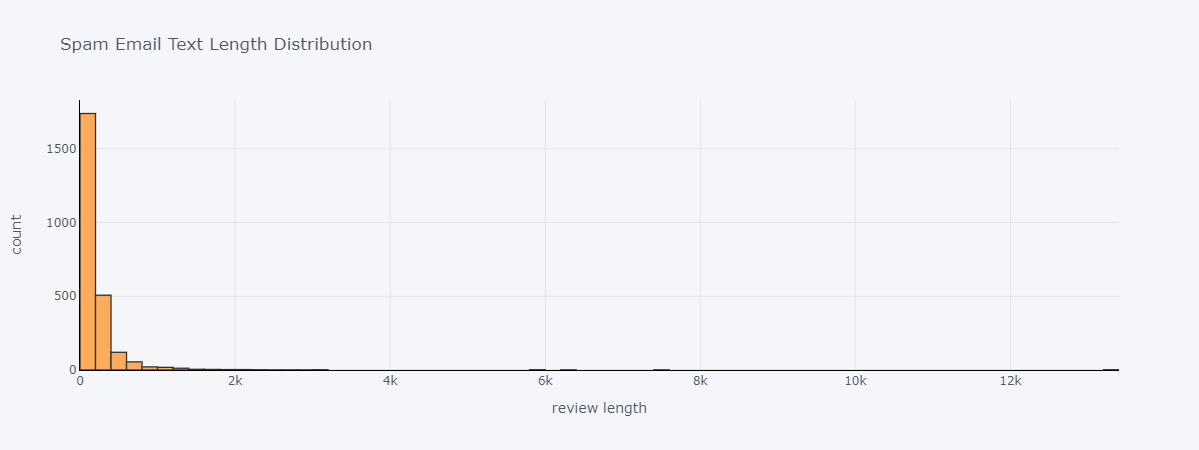

In [20]:
df[df['label']==0]['count'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Spam Email Text Length Distribution')

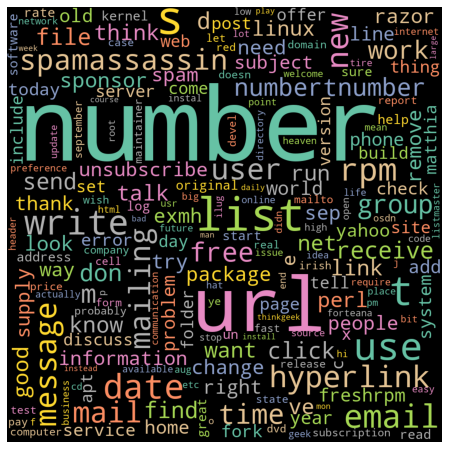

In [21]:
fig = plt.figure(figsize=(20,8))

text = ' '.join(f.loc[f['count']<=199,'email'].values)
wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).generate(text)

plt.imshow(wc)
plt.axis("off");

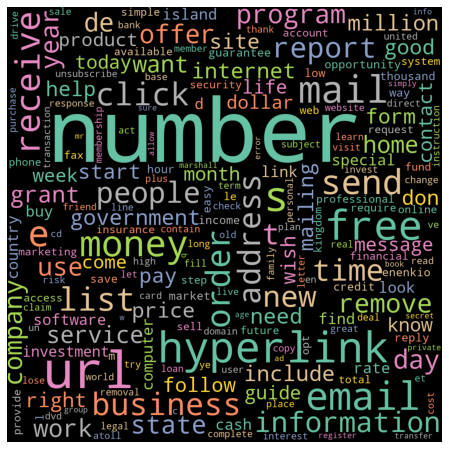

In [22]:
fig = plt.figure(figsize=(20,8))

text = ' '.join(f.loc[f['label']==1,'email'].values)
wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).generate(text)

plt.imshow(wc)
plt.axis("off");

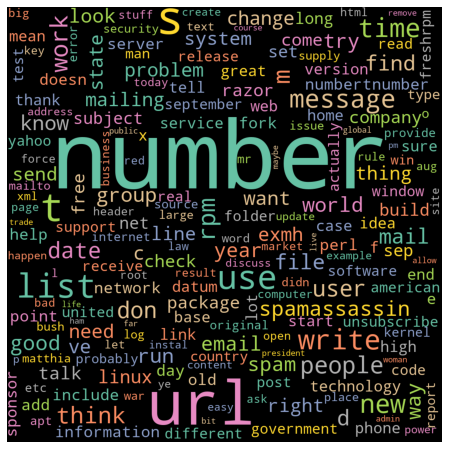

In [23]:
fig = plt.figure(figsize=(20,8))

text = ' '.join(f.loc[f['label']==0,'email'].values)
wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).generate(text)

plt.imshow(wc)
plt.axis("off");

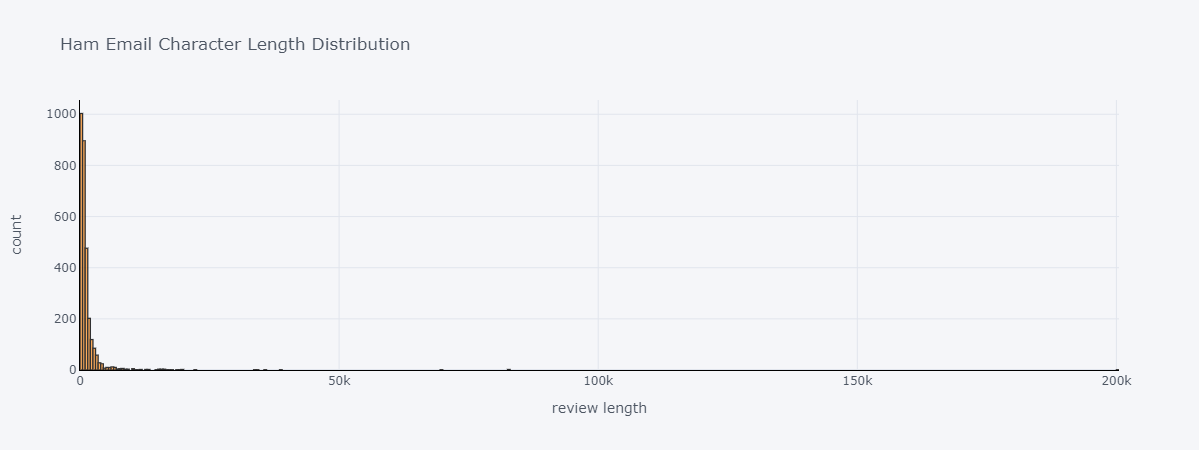

In [24]:
df['char count'].iplot(
    kind='hist',
    bins=1000,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Ham Email Character Length Distribution')

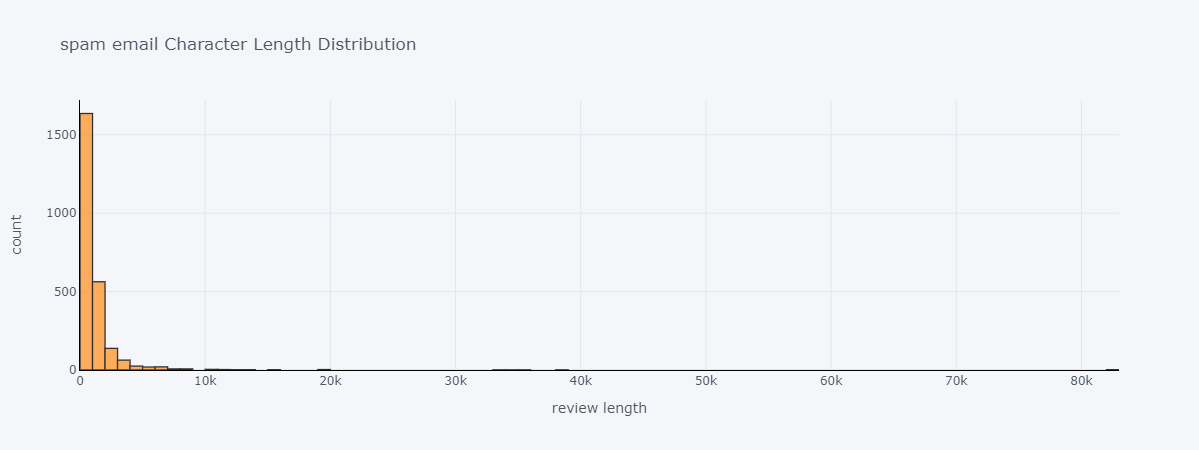

In [25]:
df[df['label']==0]['char count'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='spam email Character Length Distribution')

In [34]:
import seaborn as sns

<AxesSubplot:xlabel='label', ylabel='count'>

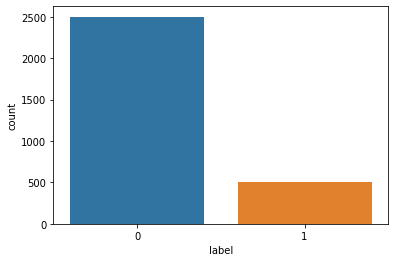

In [43]:
sns.countplot(x ='label', data = df)

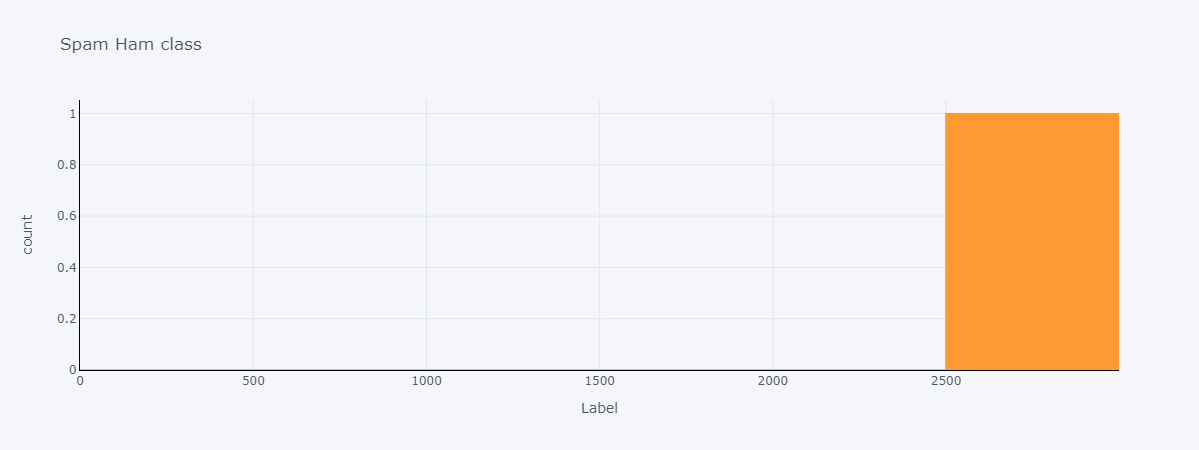

In [26]:
df['label'].iplot(
    kind='bar',
    xTitle='Label',
    linecolor='black',
    yTitle='count',
    title='Spam Ham class')

In [27]:
#splitting the data
X = df["email"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=345, stratify=y)

In [30]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=STOP_WORDS)),
                ('smote', SMOTE(random_state=12)),
                ('clf', BernoulliNB(alpha=10 ** -6)),
            ])

In [33]:
NB_pipeline.fit(X_train, y_train)
y_test_pred = NB_pipeline.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       625
           1       1.00      0.54      0.70       125

    accuracy                           0.92       750
   macro avg       0.96      0.77      0.83       750
weighted avg       0.93      0.92      0.91       750

